In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1E5kI8CLoC-XffqQMTWwSpBIPp1Wb2tne'})
download.GetContentFile('train.tar.7z')
download = drive.CreateFile({'id': '1C0-mc0WAIdssS5KJwOjghaWaqiImZZUr'})
download.GetContentFile('test.tar.7z')

In [ ]:
!7z x -so train.tar.7z | tar xf - -C ./
!7z x -so test.tar.7z | tar xf - -C ./

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [ ]:
cpu_count = mp.cpu_count()
print(cpu_count)

2


In [1]:
import cv2
from google.colab.patches import cv2_imshow
import math
from os import walk


def dataset_train_dicts(path):
  data_dicts = []
  idx = 0
  mypath = '/content/Synthetic Train Set - Detection & Recognition/Annotation'
  for (dirpath, dirnames, filenames) in walk(mypath):
    
    if len(filenames)==0:
      continue 
      
    loc = dirpath.split('/');
    t='/'.join(loc[:-2])+'/Image/'+loc[-1]
    for i in filenames[:50]:
      
      # print(i,i[:-4])
      file_n=i[:-4]+'.jpg'
      
      filename = os.path.join(t,file_n)
      print(filename)
      img=cv2.imread(filename)
      # cv2_imshow(img)
      height, width = cv2.imread(filename).shape[:2]
      # print(height, width)
      
      
      im_path = filename
      img = cv2.imread(filename)
      with open(os.path.join(dirpath,i)) as f:
        lines = f.readlines()

      for line in lines:
        record = {}
        pos = line.split(' ')
        # print(pos)
        px=[float(j) for j in pos[:4]]
        py=[float(j) for j in pos[4:-1]]
        record['file_name'] = '/content/data/{}.jpg'.format(str(idx))
        record['text'] = pos[-1][:-1]
        idx+=1
        record['box'] = [np.min(px), np.min(py), np.max(px), np.max(py)]
        
        # cv2_imshow(img)
        crop_img = img[math.ceil(record['box'][1]):math.ceil(record['box'][3]), math.ceil(record['box'][0]):math.ceil(record['box'][2])] # Crop from {x, y, w, h } => {0, 0, 300, 400}
        shape = crop_img.shape
        if shape[0]*shape[1]*shape[2]==0:
          continue
        im = cv2.resize(crop_img, (200,50), interpolation = cv2.INTER_AREA)
        # print(record['text'])
        # cv2_imshow(im)
        cv2.imwrite(record['file_name'], im)
        # record['image'] = im
        
        
        data_dicts.append(record)
      
  print(data_dicts)
  return data_dicts  

In [ ]:
!rm -rf /content/data
!mkdir /content/data

In [ ]:
train_data = dataset_train_dicts('/content')

/content/Synthetic Train Set - Detection & Recognition/Image/10/3801.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/3580.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/2098.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/425.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/486.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/2556.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/3117.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/2408.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/114.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/1817.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/4431.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/4555.jpg
/content/Synthetic Train Set - Detection & Recognition/Image/10/3378.jpg
/content/Synthetic Train Set - Detection & Recognition

In [ ]:
print(len(train_data))

7132


In [ ]:
# !rm -rf /content/data
!mkdir /content/test_dataset

In [ ]:
def dataset_test_dicts(path):
  data_dicts = []
  idx=0
  with open('/content/cropped_data/annotations.txt') as f:
        lines = f.readlines()
  for line in lines:
        record = {}
        pos = line.split('\t')
        # print(pos)
        record['file_name'] = '/content/test_dataset/{}.jpg'.format(str(idx))
        idx+=1
        record['text'] = pos[1]
        
        
        img = cv2.imread('/content/cropped_data/'+pos[0])
        
        # if img==None:
        #   continue
        # cv2_imshow(img)
        im = cv2.resize(img, (200,50), interpolation = cv2.INTER_AREA)
        # print(record['text'])
        # cv2_imshow(im)
        cv2.imwrite(record['file_name'], im)
        
        # record['image'] = im
        
        
        data_dicts.append(record)
      
      
  print(data_dicts)
  return data_dicts  
      
      
      

In [ ]:
test_data = dataset_test_dicts('/content')

[{'file_name': '/content/test_dataset/0.jpg', 'text': 'जल'}, {'file_name': '/content/test_dataset/1.jpg', 'text': 'शोध'}, {'file_name': '/content/test_dataset/2.jpg', 'text': 'न'}, {'file_name': '/content/test_dataset/3.jpg', 'text': 'संयंत्र'}, {'file_name': '/content/test_dataset/4.jpg', 'text': 'बिना'}, {'file_name': '/content/test_dataset/5.jpg', 'text': 'आज्ञा'}, {'file_name': '/content/test_dataset/6.jpg', 'text': 'प्रवेश'}, {'file_name': '/content/test_dataset/7.jpg', 'text': 'निषेध'}, {'file_name': '/content/test_dataset/8.jpg', 'text': 'नगर'}, {'file_name': '/content/test_dataset/9.jpg', 'text': 'पालिका'}, {'file_name': '/content/test_dataset/10.jpg', 'text': 'परिषद'}, {'file_name': '/content/test_dataset/11.jpg', 'text': 'इटारसी'}, {'file_name': '/content/test_dataset/12.jpg', 'text': 'जिला'}, {'file_name': '/content/test_dataset/13.jpg', 'text': 'होशंगाबाद'}, {'file_name': '/content/test_dataset/14.jpg', 'text': 'मप्र'}, {'file_name': '/content/test_dataset/15.jpg', 'text': 

पता


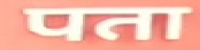

दूर


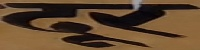

समिति


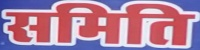

करें


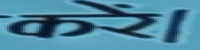

परियोजनाए


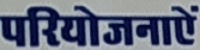

है


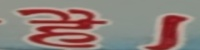

फो


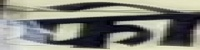

शराब


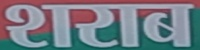

भावसार


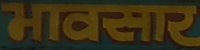

डी


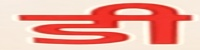

In [ ]:
import random

for data in random.sample(test_data,10):
  im_path = data['file_name']
  img = cv2.imread(im_path)
  print(data['text'])
  # cv2_imshow(img)
  # crop_img = img[math.ceil(data['box'][1]):math.ceil(data['box'][3]), math.ceil(data['box'][0]):math.ceil(data['box'][2])] # Crop from {x, y, w, h } => {0, 0, 300, 400}
  # shape = crop_img.shape
  # if shape[0]*shape[1]*shape[2]==0:
    # continue
  
  # im = cv2.resize(crop_img, (200,50), interpolation = cv2.INTER_AREA)
  cv2_imshow(img)
  
  
  # cv2.imshow("cropped", crop_img)
  # cv2.waitKey(0)


In [ ]:
letters = [chr(alpha) for alpha in range(2304, 2432)]
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

129
['-', 'ऀ', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', 'ऺ', 'ऻ', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॎ', 'ॏ', 'ॐ', '॑', '॒', '॓', '॔', 'ॕ', 'ॖ', 'ॗ', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', 'ॣ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॳ', 'ॴ', 'ॵ', 'ॶ', 'ॷ', 'ॸ', 'ॹ', 'ॺ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']
{0: '-', 1: 'ऀ', 2: 'ँ', 3: 'ं', 4: 'ः', 5: 'ऄ', 6: 'अ', 7: 'आ', 8: 'इ', 9: 'ई', 10: 'उ', 11: 'ऊ', 12: 'ऋ', 13: 'ऌ', 14: 'ऍ', 15: 'ऎ', 16: 'ए', 17: 'ऐ', 18: 'ऑ', 19: 'ऒ', 20: 'ओ', 21: 'औ', 22: 'क', 23: 'ख', 24: 'ग', 25: 'घ', 26: 'ङ', 27: 'च', 28: 'छ', 29: 'ज', 30: 'झ', 31: 'ञ', 32: 'ट', 33: 'ठ', 34: 'ड', 35: 'ढ', 36: 'ण', 37: 'त', 38: 'थ', 39: 'द',

In [ ]:
batch_size = 16


In [ ]:
class TEXTDataset(Dataset):
    
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index]
        image_fp = img['file_name']
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = img['text']
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
trainset = TEXTDataset(train_data) 
testset = TEXTDataset(test_data)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader))

179 179


In [ ]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('पश्चिम', 'उठायें', 'वि', 'आप', 'व', 'शिवलिगम', 'जिला', 'स्वल्पाहार', 'रक्षिति', 'छात्रावास', 'करें', 'जमनिरोड़', 'नगर', 'धारा', 'बाइंडिंग', 'की')


In [ ]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 512

129


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [ ]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, rnn_hidden_size)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)

    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
text_batch_logits = crnn(image_batch)
print(text_batch)
print(text_batch_logits.shape)

('पश्चिम', 'उठायें', 'वि', 'आप', 'व', 'शिवलिगम', 'जिला', 'स्वल्पाहार', 'रक्षिति', 'छात्रावास', 'करें', 'जमनिरोड़', 'नगर', 'धारा', 'बाइंडिंग', 'की')
torch.Size([10, 16, 129])


In [ ]:
criterion = nn.CTCLoss(blank=0)

In [ ]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [ ]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-5
clip_norm = 10

In [ ]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

In [ ]:
torch.save(crnn, 'first_model_crnn.pt')

In [ ]:
rcn = torch.load('first_model_crnn.pt')
crnn=rcn

In [ ]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = rcn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(rcn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

Epoch:1    Loss:2.0493441110246637    NumUpdates:445


Epoch:2    Loss:2.0491853226436656    NumUpdates:445


Epoch:3    Loss:2.04959798394964    NumUpdates:445


Epoch:4    Loss:2.049227652656898    NumUpdates:445
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.


Epoch:5    Loss:2.0492201384533657    NumUpdates:445


Epoch:6    Loss:2.049039066507575    NumUpdates:445


Epoch:7    Loss:2.049108692501368    NumUpdates:445


Epoch:8    Loss:2.0492297017172483    NumUpdates:445


Epoch:9    Loss:2.0490335453762096    NumUpdates:445
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.


Epoch:10    Loss:2.048955408107029    NumUpdates:445


Epoch:11    Loss:2.0499010174461967    NumUpdates:445


Epoch:12    Loss:2.0483933502368714    NumUpdates:445


Epoch:13    Loss:2.04931463686268    NumUpdates:445


Epoch:14    Loss:2.0491748823208757    NumUpdates:445


Epoch:15    Loss:2.049666194969349    NumUpdates:445
Epoch    15: reducing learning rate of group 0 to 1.0000e-06.


Epoch:16    Loss:2.0486800150924855    NumUpdates:445


Epoch:17    Loss:2.0489326578847478    NumUpdates:445


Epoch:18    Loss:2.0489570414082388    NumUpdates:445
Epoch    18: reducing learning rate of group 0 to 1.0000e-07.


Epoch:19    Loss:2.0497843986146904    NumUpdates:445


Epoch:20    Loss:2.049216220084201    NumUpdates:445



In [ ]:
!cp -r 'first_model_crnn.pt' 'gdrive/My Drive/'

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [ ]:
print(results_train.shape)
results_train.head()

(2862, 2)


,actual,prediction
0,कर,-------ककर
1,कर,-------ककर
2,आज,-------आआज
3,तक,-------तकक
4,दरिद्र,------दद्र


In [ ]:
print(results_test.shape)
results_test.head()

(2862, 2)


,actual,prediction
0,कर,-------ककर
1,कर,-------ककर
2,आज,-------आआज
3,तक,-------तकक
4,दरिद्र,------दद्र


In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()


,actual,prediction,prediction_corrected
0,कर,-------ककर,कर
1,कर,-------ककर,कर
2,आज,-------आआज,आज
3,तक,-------तकक,तक
4,दरिद्र,------दद्र,द्र


In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,कर,-------ककर,कर
1,कर,-------ककर,कर
2,आज,-------आआज,आज
3,तक,-------तकक,तक
4,दरिद्र,------दद्र,द्र


In [ ]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
4,दरिद्र,------दद्र,द्र
6,टपकता,-------कता,कता
7,रहता,-------हहा,हा
12,रहती,-------हही,ही
18,मकान,------ककान,कान
...,...,...,...
2842,करके,------ककके,के
2852,छन,--------नन,न
2853,स्तर,-------्तर,्तर
2854,भारतीय,-----ारतीय,ारतीय


In [ ]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

3    221
2    208
1     38
4     31
5      3
Name: prediction_corrected, dtype: int64


In [ ]:
mask = mistakes_df['prediction_corrected'].str.len() == 2
mistakes_df[mask]

,actual,prediction,prediction_corrected
7,रहता,-------हहा,हा
12,रहती,-------हही,ही
40,पथिक,-------िकक,िक
49,फौज,--------ौज,ौज
70,शौक,-------ौौक,ौक
...,...,...,...
2827,सुबह,-------ुहह,ुह
2835,गोइ,-------गोो,गो
2841,ढ़ग,--------ढग,ढग
2842,करके,------ककके,के


In [ ]:
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.8249475890985325
